# LAB 03 - MLB ALL-STAR GAME

---
embed-resources: true
---

## Introduction

In this study, we develop a model to predict the type of pitch a pitcher will throw based on key pitch characteristics. The model leverages historical pitch data, including velocity, spin rate, and movement metrics, to estimate the most likely pitch type. By analyzing these factors, we aim to provide a data-driven approach to pitch prediction, which can be useful for players, coaches, and analysts. While the model offers valuable insights, it does not account for situational factors such as batter tendencies, game context, or pitcher strategy, which should also be considered in real-time decision-making.

## Methods

In [2]:
# basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

# preprocessing imports
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline


### Data

In [3]:
# load data
pitches_train = pd.read_parquet(
    "https://cs307.org/lab/data/pitches-train.parquet",
)
pitches_test = pd.read_parquet(
    "https://cs307.org/lab/data/pitches-test.parquet",
)

In [4]:
# Define features and target
numeric_features = ['release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z']
categorical_features = ['stand']
target_column = 'pitch_name'

### Dataset Description

The train data contains one row per pitch from the pitches_train dataset.
The test data contains one row per pitch from the pitches_test dataset.

Each row represents a single pitch, including its velocity, spin rate, movement, and other characteristics used to classify pitch types.

The variables considered are:

#### Response

**`pitch_name`**  
- `object` : The name of the pitch, which represents the type of pitch thrown.

#### Features

**`release_speed`**  
- `float64` : The velocity of the pitch (miles per hour) measured shortly after leaving the pitcher’s hand.

**`release_spin_rate`**  
- `float64` : The spin rate of the pitch (revolutions per minute) measured shortly after leaving the pitcher’s hand.

**`pfx_x`**  
- `float64` : The horizontal movement (feet) of the pitch from the catcher’s perspective.

**`pfx_z`**  
- `float64` : The vertical movement (feet) of the pitch from the catcher’s perspective.

**`stand`**  
- `object` : The side of the plate the batter is standing on, either **L** (left) or **R** (right).


In [5]:
pitches_train.head()

,pitch_name,release_speed,release_spin_rate,pfx_x,pfx_z,stand
0,Sweeper,84.7,2667.0,1.25,0.01,R
1,Sweeper,83.9,2634.0,1.41,0.20,R
2,Sweeper,84.4,2526.0,1.26,0.25,R
3,Curveball,74.3,2389.0,0.93,-1.10,L
4,Sweeper,85.6,2474.0,1.08,0.52,R


In [6]:
pitches_test.head()

,pitch_name,release_speed,release_spin_rate,pfx_x,pfx_z,stand
0,4-Seam Fastball,94.2,2080.0,-0.22,1.10,R
1,4-Seam Fastball,92.6,2021.0,-0.86,1.25,L
2,Sweeper,81.1,2398.0,1.20,0.29,R
3,Sweeper,79.9,2314.0,1.28,0.47,R
4,4-Seam Fastball,93.1,2018.0,-0.36,0.92,R


### Summary Statistics

In [7]:
# summary statistics
fastball = pitches_train[pitches_train["pitch_name"] == "4-Seam Fastball"]
curveball = pitches_train[pitches_train["pitch_name"] == "Curveball"]
cutter = pitches_train[pitches_train["pitch_name"] == "Cutter"]
sinker = pitches_train[pitches_train["pitch_name"] == "Sinker"]
slider = pitches_train[pitches_train["pitch_name"] == "Slider"]
splitter = pitches_train[pitches_train["pitch_name"] == "Split-Finger"]
sweeper = pitches_train[pitches_train["pitch_name"] == "Sweeper"]

print(f"Target Balance")
print(f"Fastball --> Count: {len(fastball)} || Proportion: {len(fastball)/len(pitches_train)}" )
print(f"Curveball --> Count: {len(curveball)} || Proportion: {len(curveball)/len(pitches_train)}" )
print(f"Cutter --> Count: {len(cutter)} || Proportion: {len(cutter)/len(pitches_train)}" )
print(f"Sinker --> Count: {len(sinker)} || Proportion: {len(sinker)/len(pitches_train)}" )
print(f"Slider --> Count: {len(slider)} || Proportion: {len(slider)/len(pitches_train)}" )
print(f"Splitter --> Count: {len(splitter)} || Proportion: {len(splitter)/len(pitches_train)}" )
print(f"Sweeper --> Count: {len(sweeper)} || Proportion: {len(sweeper)/len(pitches_train)}\n" )

print("Velocity by Pitch Type")
print(f"Fastball --> Mean: {fastball['release_speed'].mean()} || Std: {fastball['release_speed'].std()}")
print(f"Curveball --> Mean: {curveball['release_speed'].mean()} || Std: {curveball['release_speed'].std()}")
print(f"Cutter --> Mean: {cutter['release_speed'].mean()} || Std: {cutter['release_speed'].std()}")
print(f"Sinker --> Mean: {sinker['release_speed'].mean()} || Std: {sinker['release_speed'].std()}")
print(f"Slider --> Mean: {slider['release_speed'].mean()} || Std: {slider['release_speed'].std()}")
print(f"Splitter --> Mean: {splitter['release_speed'].mean()} || Std: {splitter['release_speed'].std()}")
print(f"Sweeper --> Mean: {sweeper['release_speed'].mean()} || Std: {sweeper['release_speed'].std()}\n")

print("Spin Rate by Pitch Type")
print(f"Fastball --> Mean: {fastball['release_spin_rate'].mean()} || Std: {fastball['release_spin_rate'].std()}")
print(f"Curveball --> Mean: {curveball['release_spin_rate'].mean()} || Std: {curveball['release_spin_rate'].std()}")
print(f"Cutter --> Mean: {cutter['release_spin_rate'].mean()} || Std: {cutter['release_spin_rate'].std()}")
print(f"Sinker --> Mean: {sinker['release_spin_rate'].mean()} || Std: {sinker['release_spin_rate'].std()}")
print(f"Slider --> Mean: {slider['release_spin_rate'].mean()} || Std: {slider['release_spin_rate'].std()}")
print(f"Splitter --> Mean: {splitter['release_spin_rate'].mean()} || Std: {splitter['release_spin_rate'].std()}")
print(f"Sweeper --> Mean: {sweeper['release_spin_rate'].mean()} || Std: {sweeper['release_spin_rate'].std()}")

Target Balance
Fastball --> Count: 718 || Proportion: 0.2732115677321157
Curveball --> Count: 222 || Proportion: 0.08447488584474885
Cutter --> Count: 233 || Proportion: 0.08866057838660578
Sinker --> Count: 97 || Proportion: 0.03691019786910198
Slider --> Count: 63 || Proportion: 0.023972602739726026
Splitter --> Count: 312 || Proportion: 0.1187214611872146
Sweeper --> Count: 983 || Proportion: 0.3740487062404871

Velocity by Pitch Type
Fastball --> Mean: 97.27061281337046 || Std: 1.6992696480040412
Curveball --> Mean: 77.67972972972974 || Std: 3.215206223221953
Cutter --> Mean: 90.7420600858369 || Std: 2.3644892748449693
Sinker --> Mean: 97.16082474226806 || Std: 1.829592207582911
Slider --> Mean: 85.2031746031746 || Std: 2.4015430694000277
Splitter --> Mean: 89.29134615384616 || Std: 1.7592992563408207
Sweeper --> Mean: 85.33641912512718 || Std: 1.8625520114173113

Spin Rate by Pitch Type
Fastball --> Mean: 2217.331932773109 || Std: 114.75468274404717
Curveball --> Mean: 2482.666666

#### Target Balance  
The dataset contains seven different pitch types, with Sweeper being the most common at 37.4% of all pitches, followed by Fastball at 27.3% and Splitter at 11.9%. On the other hand, Slider, Sinker, and Curveball are the least frequent, making up only a small portion of the data. This imbalance suggests that the model may have more difficulty accurately classifying the less frequent pitch types. If not handled properly, the model could become biased toward predicting the more common pitches, leading to reduced performance for underrepresented classes.

#### Velocity Analysis by Pitch Type  
Fastball and Sinker have the highest average velocities at around 97 mph, indicating that these pitches rely heavily on speed. Curveball and Sweeper are the slowest, with average speeds around 77 and 85 mph, respectively, which aligns with their purpose of deceiving batters with off-speed movement. Cutter and Splitter fall in the middle of the velocity range, making them more versatile options for pitchers. The reletively low standard deviations for each pitch type suggest that while there is some variability in speed, most pitches maintain a relatively consistent velocity profile.

#### Spin Rate Analysis by Pitch Type  
Spin rate varies significantly between pitch types, with Sliders, Sweepers, and Curveballs exhibiting the highest spin rates, typically above 2400 RPM. These pitches rely on high spin to generate sharp breaking motion. In contrast, Splitters have the lowest spin rate at around 1274 RPM, which is expected since this pitch is designed to reduce backspin and create a sinking effect. Fastballs and Cutters maintain intermediate spin rates, contributing to their balance between speed and movement. The variation in spin rates highlights the differences in how each pitch achieves movement, which could be an important factor in pitch classification.


### Explaratory Visualization

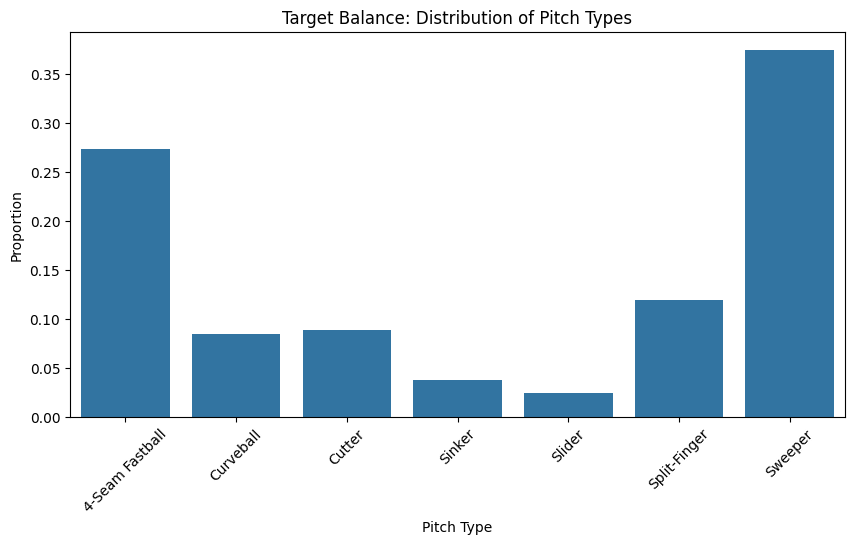

In [8]:
# exploratory visualization
pitch_types = ["4-Seam Fastball", "Curveball", "Cutter", "Sinker", "Slider", "Split-Finger", "Sweeper"]
counts = [len(pitches_train[pitches_train["pitch_name"] == pitch]) for pitch in pitch_types]
proportions = [c / sum(counts) for c in counts]

plt.figure(figsize=(10, 5))
sns.barplot(x=pitch_types, y=proportions)
plt.xlabel("Pitch Type")
plt.ylabel("Proportion")
plt.title("Target Balance: Distribution of Pitch Types")
plt.xticks(rotation=45)
plt.show()

Visualization 1 - Target Balance: Distribution of Pitch Types

The bar chart illustrates the distribution of different pitch types in the dataset. The Sweeper pitch is the most common, making up the largest proportion of the dataset, followed by 4-Seam Fastballs and Split-Finger Fastballs. In contrast, Slider, Sinker, and Curveball pitches are the least frequent, suggesting a significant class imbalance.

This imbalance could impact model performance, as the classifier may be biased toward predicting the most frequent pitch types while struggling with the underrepresented ones. Specifically, the limited number of Slider and Sinker pitches in the training set may lead to poor prediction accuracy for these pitches on the test set. Additionally, the imbalance could distort the model’s ability to differentiate between similar pitch types, further affecting overall classification accuracy.


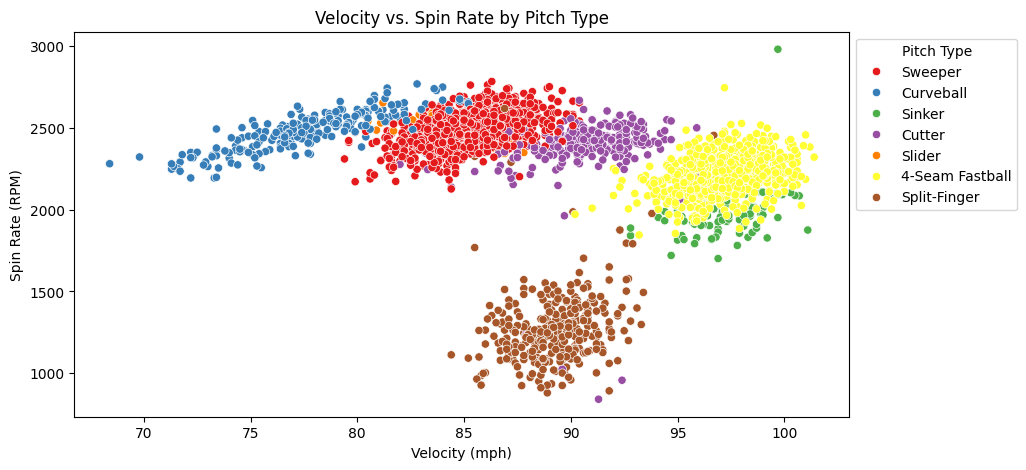

In [9]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x="release_speed", y="release_spin_rate", hue="pitch_name", data=pitches_train, palette="Set1")
plt.xlabel("Velocity (mph)")
plt.ylabel("Spin Rate (RPM)")
plt.title("Velocity vs. Spin Rate by Pitch Type")
plt.legend(title="Pitch Type", bbox_to_anchor=(1, 1))
plt.show()

Visualization 2 - Velocity vs. Spin Rate by Pitch Type

The scatter plot demonstrates the relationship between pitch velocity and spin rate, with each point color-coded by pitch type. The clusters indicate clear separations between different pitch types based on these two metrics. Fastballs and Sinkers are characterized by high velocity and moderate spin rates, while Sweepers and Curveballs have relatively lower velocities but higher spin rates, consistent with their breaking ball nature. The Split-Finger fastball forms a distinct cluster with both low velocity and spin, reinforcing its classification as a pitch designed for downward movement rather than horizontal break. The strong separation among different pitch types suggests that velocity and spin rate are strong predictors for classifying pitches.

I find this visualization fascinating because it highlights the importance of variable frequency in classification models. It also reveals how closely related different pitch types are, emphasizing that the more data available for each pitch, the easier it becomes to predict the type as it leaves the pitcher’s hand. For example, predicting whether a pitch is a Slider is particularly challenging because it shares characteristics with both Curveballs and Sweepers—two pitches that essentially define what a Slider is. This visualization is especially compelling because it conveys a Venn diagram-like relationship between pitch types, illustrating their overlap and distinctions in a visually intuitive way.

### Models

In [10]:
# create X and y for train
X_train = pitches_train.drop("pitch_name", axis=1)
y_train = pitches_train["pitch_name"]

# create X and y for test
X_test = pitches_test.drop("pitch_name", axis=1)
y_test = pitches_test["pitch_name"]

In [11]:
samples, features = X_train.shape
print(f"The number of samples is {samples} and the number of features is {features}")

The number of samples is 2628 and the number of features is 5


In [12]:
# train models
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="infrequent_if_exist")
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    remainder="drop"
)

k_values = list(range(1, 21))
cv_scores = []

for k in k_values:
    model = make_pipeline(
        preprocessor,
        KNeighborsClassifier(n_neighbors=k)
    )
    
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    cv_scores.append(scores.mean())

best_k = k_values[np.argmax(cv_scores)]


In [13]:
mod = make_pipeline(
    preprocessor,
    KNeighborsClassifier(n_neighbors=best_k)
)

mod.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['release_speed',
                                                   'release_spin_rate', 'pfx_x',
                                                   'pfx_z']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                                  ['stand'])])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=14))])

We use a K-Nearest Neighbors classifier, selecting the optimal k through cross-validation. Numeric features are scaled, and categorical features are one-hot encoded. The final model is trained with the best k for improved classification accuracy.

## Results

In [14]:
# report model metrics
y_test_pred = mod.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.9397664413030117


This section shows that the test accuracy of the model is 0.9397664413030117, indicating that the model correctly predicts outcomes 93.9766% of the time.

In [15]:
# summary figure
y_proba = mod.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_proba, multi_class="ovr")

print(f"KNN AUC Score (OvR): {auc_score:.4f}")

KNN AUC Score (OvR): 0.9815


The AUC score measures the model's ability to distinguish between pitch types. An AUC score of 0.9815 indicates that the K-Nearest Neighbors classifier performs exceptionally well, meaning it can correctly rank predictions with high confidence. The one-vs-rest approach ensures that the model evaluates each pitch type against all others, making this a strong indicator of overall classification performance.

In [16]:
report = classification_report(y_test, y_test_pred, target_names=mod.classes_)
print(report)

                 precision    recall  f1-score   support

4-Seam Fastball       0.97      1.00      0.99       501
      Curveball       0.87      1.00      0.93        46
         Cutter       0.97      0.79      0.87       274
         Sinker       0.97      0.85      0.91       120
         Slider       0.03      1.00      0.05         1
   Split-Finger       0.94      0.94      0.94       107
        Sweeper       0.96      0.98      0.97       578

       accuracy                           0.94      1627
      macro avg       0.81      0.94      0.81      1627
   weighted avg       0.96      0.94      0.95      1627



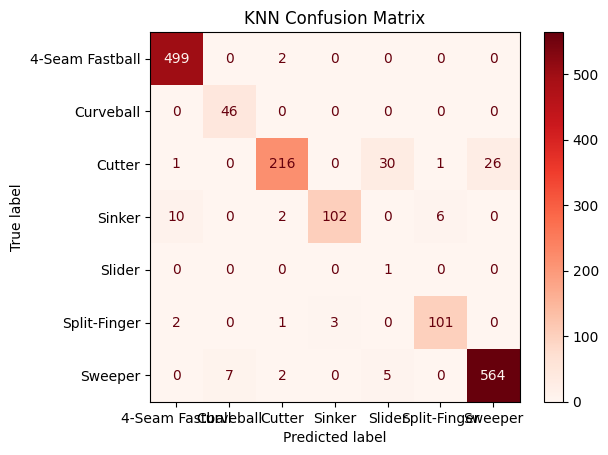

In [17]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=mod.classes_)
disp.plot(cmap="Reds")
plt.title("KNN Confusion Matrix")
plt.show()

The classification report and confusion matrix provide a detailed evaluation of the K-Nearest Neighbors (KNN) model’s performance in predicting pitch types. The model achieves a high overall accuracy of 94%, with particularly strong performance for 4-Seam Fastballs, Curveballs, and Sweepers, as indicated by their high precision, recall, and F1-scores. The Sweeper and Cutter pitches also show strong classification performance, though Cutters exhibit a slightly lower recall (0.79), suggesting some misclassification.

The confusion matrix highlights key areas where the model struggles, particularly with Sliders, which have 100% recall but extremely low precision (0.03). This indicates that while all actual Sliders were correctly identified, many non-Sliders were misclassified as Sliders, leading to significant false positives. Additionally, some Cutters were misclassified as Sweepers, suggesting possible overlap in their movement or velocity characteristics. While the model performs well for frequent pitch types, further adjustments may be needed to improve precision for underrepresented classes.

In [18]:
# serialize model
from joblib import dump
dump(mod, "pitches.joblib")

['pitches.joblib']

## Discussion and Conclusion  

In conclusion, I would choose to use this K-Nearest Neighbors (KNN) model because of its high accuracy of 94%. The model effectively classifies the majority of pitch types and provides valuable insights into pitch prediction. However, certain pitch types, particularly those with low precision and recall, could benefit from additional support to improve their classification. Rather than discarding the model, I would focus on either increasing the representation of underrepresented pitch types or simulating additional data to enhance the training and testing sets.  

### Key Limitations  

One limitation of this model is its tendency to misclassify certain pitch types, particularly Sliders, which have a recall of 1.00, but a precision of only 0.03. This means that while all actual Sliders are correctly identified, many non-Sliders are also classified as Sliders, leading to a high number of false positives. Similarly, Cutters and Sinkers exhibit moderate recall scores, suggesting that the model occasionally confuses these pitch types with others that share similar characteristics. Additionally, although it is expected because of the tendencies of modern MLB pitchers, the dataset is imbalanced, with Sweepers and Fastballs being significantly more frequent than other pitches. This imbalance likely contributes to the model favoring common pitch types while struggling with less frequent ones.  

### Potential Risks and Adjustments  

If implemented in its current state, the model could lead to some misclassifications that affect strategic decision-making for batters, pitchers, and coaches. For example, if a batter expects a Slider based on the model’s prediction but the pitch is actually a Sweeper or Curveball, they might misread the movement and reduce their chances of making solid contact. Additionally, pitchers might receive incorrect feedback about their pitch tendencies, which could impact their game strategy. The high rate of false positives for some pitch types could also make it difficult to trust the model in high-pressure game situations. However, these risks could be mitigated by increasing the support for underrepresented pitch types, either by collecting more data or by simulating additional samples to balance the dataset.  

### Improvements Needed for Practical Use  

To make this model more effective for real-world applications, several improvements should be considered:  

1. Increasing the support for low-precision and low-recall pitch types through additional data collection or synthetic data generation to balance the dataset.  
2. Refining feature selection by incorporating additional movement-based metrics, such as break length or vertical approach angle, to improve pitch differentiation.  
3. Fine-tuning hyperparameters, such as testing different distance metrics or adjusting the number of neighbors, to optimize classification for closely related pitches.  

### Conclusion  

This KNN model demonstrates strong overall classification performance and is a viable tool for pitch classification. The primary limitation lies in the misclassification of certain underrepresented pitch types, which can be addressed by increasing data support or simulating additional training samples. With further refinement, this model could become even more reliable, providing valuable insights for players, coaches, and analysts in understanding and predicting pitch tendencies.  
